In [423]:
import anndata as ad
import pandas as pd
import os
import yaml
import numpy as np

In [424]:
# path to the resources directory that stores the results of the runs
path_to_data = "../../task-dge-perturbation-prediction/resources/"
path_to_results = os.path.join(path_to_data, "runs/run_2024-06-02_22-27-09")

In [425]:
def mrrmse(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_rowwise_rmse = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_rmse += np.sqrt((diff**2).mean())
    mean_rowwise_rmse /= de_test_X.shape[0]
    return mean_rowwise_rmse

In [426]:
def mmae(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_rowwise_mae = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            diff = np.clip(de_test_X[i,], -threshold, threshold)  - np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            diff = de_test_X[i,] - prediction.iloc[i]
        mean_rowwise_mae += np.abs(diff).mean()
    
    mean_rowwise_mae /= de_test_X.shape[0]
    return mean_rowwise_mae

In [427]:
def cosine_similarity(de_test_X, prediction, threshold=-np.log10(0.0001)):
    mean_cosine_similarity = 0
    for i in range(de_test_X.shape[0]):
        if threshold is not None:
            y_i = np.clip(de_test_X[i,], -threshold, threshold)
            y_hat_i = np.clip(prediction.iloc[i], -threshold, threshold)
        else:
            y_i = de_test_X[i,]
            y_hat_i = prediction.iloc[i]
    
        dot_product = np.dot(y_i, y_hat_i)
    
        norm_y_i = np.linalg.norm(y_i)
        norm_y_hat_i = np.linalg.norm(y_hat_i)
    
        cosine_similarity = dot_product / (norm_y_i * norm_y_hat_i)
    
        mean_cosine_similarity += cosine_similarity
    
    mean_cosine_similarity /= de_test_X.shape[0]
    return mean_cosine_similarity

In [428]:
# de_test = pd.read_parquet(os.path.join(path_to_data, "neurips-2023-data", "de_test.parquet")).set_index("id")
de_test = ad.read_h5ad(os.path.join(path_to_data, "de_test.h5ad"))

In [429]:
# reorder according to the old id_map

In [430]:
sign_log10_pval_df = pd.DataFrame(de_test.layers['sign_log10_pval'], index=de_test.obs.index, columns=de_test.var_names)
de_test = pd.concat([de_test.obs, sign_log10_pval_df], axis=1)

In [431]:
with open(os.path.join(path_to_results, "score_uns.yaml"), 'r') as file:
    data = yaml.safe_load(file)

# Generate paths
rows = []
for entry in data:
    dataset_id = entry['dataset_id']
    if dataset_id == 'neurips-2023-kaggle':
        continue
    method_id = entry['method_id']
    metric_ids = entry.get('metric_ids', [])
    metric_values = entry.get('metric_values', [])
    for index, metric_id in enumerate(metric_ids):
        metric_value = metric_values[index] if index < len(metric_values) else 'Unknown_value'
        path = f"{dataset_id}.{method_id}.{method_id}.output.h5ad"
        rows.append({
                'method_id': method_id,
                metric_id: metric_value,
                'path': path
            })

In [432]:
df = pd.DataFrame(rows)

In [433]:
df = df[~df.method_id.isin(["zeros", "ground_truth"])]

In [434]:
predictions = {}
for method_id in ["jn_ap_op2", "lgc_ensemble", "nn_retraining_with_pseudolabels", "scape", "pyboost", "mean_across_celltypes", "transformer_ensemble"]:
    predictions[method_id] = pd.DataFrame(ad.read_h5ad(os.path.join(path_to_results, "predictions", f"neurips-2023-data.{method_id}.{method_id}.output.h5ad")).layers["prediction"], columns=de_test.columns[7:])

In [435]:
de_test.index = predictions["pyboost"].index

In [436]:
rows = []
for method_id in predictions.keys():
    for cell_type in de_test.cell_type.unique():
        rows.append({
            'method_id': method_id,
            'cell_type': cell_type,
            'mrrmse': mrrmse(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type]),
            'mae': mmae(de_test.loc[de_test.cell_type == cell_type, predictions[method_id].columns].values, predictions[method_id][de_test.cell_type == cell_type])
        })

In [437]:
results_per_method = pd.DataFrame(rows)

In [438]:
method_id

'transformer_ensemble'

In [439]:
results_per_method

,method_id,cell_type,mrrmse,cosine_sim,mae
0,jn_ap_op2,B cells,0.776189,0.354376,0.563567
1,jn_ap_op2,Myeloid cells,1.011030,0.302993,0.734019
2,lgc_ensemble,B cells,0.700655,0.444869,0.508701
3,lgc_ensemble,Myeloid cells,0.885933,0.461360,0.642606
4,nn_retraining_with_pseudolabels,B cells,0.665755,0.480116,0.479467
5,nn_retraining_with_pseudolabels,Myeloid cells,0.849077,0.506478,0.615294
6,scape,B cells,0.684632,0.460054,0.502765
7,scape,Myeloid cells,0.866539,0.490821,0.642004
8,pyboost,B cells,0.689889,0.464393,0.485161
9,pyboost,Myeloid cells,0.901329,0.465867,0.636445


In [440]:
# B cells are better predicted, but the top method outperforms the other two in both

In [441]:
rows = []
for method_id in predictions.keys():
    for sm_name in de_test.sm_name.unique():
        rows.append({
            'method_id': method_id,
            'sm_name': sm_name,
            'mrrmse': mrrmse(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'cosine_sim': cosine_similarity(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name]),
            'mae': mmae(de_test.loc[de_test.sm_name == sm_name, predictions[method_id].columns].values, predictions[method_id][de_test.sm_name == sm_name])
        })

In [442]:
data = pd.DataFrame(rows)

In [443]:
threshold = -np.log10(0.01)

In [444]:
rows = []
for sm_name in de_test.sm_name.unique():
    rows.append({
            'sm_name': sm_name,
            'sig_genes': (np.abs(de_test.loc[de_test.sm_name == sm_name].iloc[:, 6:]) > threshold).sum().sum() 
        })
sig_genes_df = pd.DataFrame(rows)

In [445]:
data["sig_genes"] = data["sm_name"].map(sig_genes_df.set_index("sm_name")["sig_genes"])

In [446]:
rename_dict = {
    'jn_ap_op2': 'JN-AP-OP2',
    'nn_retraining_with_pseudolabels': 'NN retraining with pseudolabels',
    'scape': 'ScAPE',
    'pyboost': 'Py-boost',
    'lgc_ensemble': 'LSTM-GRU-CNN Ensemble',
    "mean_across_celltypes": "Mean per cell type and gene",
    "transformer_ensemble": "Transformer Ensemble"
}
data.method_id = data.method_id.astype("category").cat.rename_categories(rename_dict)

/var/folders/98/9ygjwkpd12d1vxydfprn1st00000gp/T/ipykernel_20128/2747484096.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for method, group in data.groupby('method_id'):


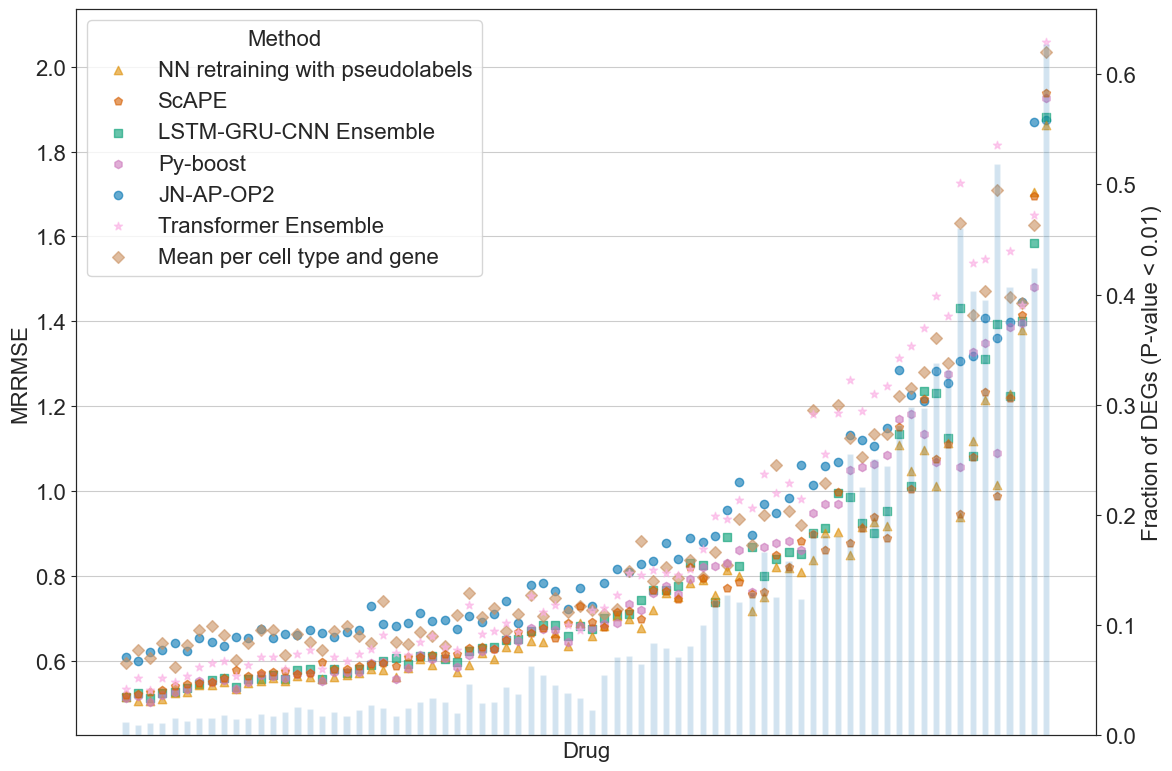

In [447]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
palette = sns.color_palette("colorblind")

sns.set_style("whitegrid")
sns.set_style("white")

# Set font size globally for the plot
matplotlib.rcParams.update({'font.size': 16})

# Add jitter to the x-axis categorical data for better visualization
# Assign a numeric value to each unique 'sm_name' for plotting
median_mrrmse = data.groupby('sm_name')['mrrmse'].median().sort_values()
categories = {name: i for i, name in enumerate(median_mrrmse.index)}
data['sm_jittered'] = data['sm_name'].map(categories)# + np.random.normal(0, 0.1, size=len(data))

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axis (primary axis)
ax2 = ax.twinx()  # Create another y-axis that shares the same x-axis (secondary axis)

# Plot bars on the secondary axis
total_genes_by_sm = data.drop_duplicates("sm_name").groupby('sm_name')['sig_genes'].sum().sort_values()
total_genes_10k = total_genes_by_sm / len(predictions["pyboost"].columns)
ax2.bar(categories.values(), total_genes_10k.loc[list(categories.keys())], alpha=0.2, label='Total Significant DEGs (10k)', width=0.5)

# Scatter plot on the primary axis
colors = {'JN-AP-OP2': 'blue', 'NN retraining with pseudolabels': 'green', "LSTM-GRU-CNN Ensemble": 'red', "ScAPE": "orange", "Py-boost": "purple", "Mean per cell type and gene": "black", "Transformer Ensemble": "gray"}
# use colors from the palette
colors = {key: palette[i] for i, key in enumerate(colors.keys())}
markers = {'JN-AP-OP2': 'o', 'NN retraining with pseudolabels': '^', "LSTM-GRU-CNN Ensemble": 's', "ScAPE": "p", "Py-boost": "h", "Mean per cell type and gene": "D", "Transformer Ensemble": "*"}
for method, group in data.groupby('method_id'):
    ax.scatter(group['sm_jittered'], group['mrrmse'], color=colors[method], marker=markers.get(method, 'o'), alpha=0.6, label=method)

# Axis and plot settings
ax.set_xticks([])  # Hide the x-axis labels
# plt.title('Per-drug MRRMSE with number of differentially expressed genes (DEGs)')
plt.title('')
ax.set_xlabel('Drug')
ax.set_ylabel('MRRMSE')
ax2.set_ylabel('Fraction of DEGs (P-value < 0.01)')
handles, labels = ax.get_legend_handles_labels()

# Define your custom order as a list of method names in the desired order
order = ["NN retraining with pseudolabels", "ScAPE", "LSTM-GRU-CNN Ensemble", "Py-boost", "JN-AP-OP2", "Transformer Ensemble", "Mean per cell type and gene"]

# Create a new list of handles for the legend by the desired label order
ordered_handles = [next(handle for label, handle in zip(labels, handles) if label == o) for o in order]

# Create the legend with the ordered handles
ax.legend(ordered_handles, order, title='Method', loc='upper left')


# Grid settings
ax.grid(True)  # Enable grid for the primary axis
ax2.grid(False)  # Disable grid for the secondary axis

plt.tight_layout()  # Adjust layout to make room for label rotation
plt.savefig("results_per_compound_reannotated.svg", transparent=True)
plt.show()

In [448]:
# load moa
moa_annotations = pd.read_csv(os.path.join("../data/complete_data", "moa_annotations.csv"))

In [449]:
data_top = data[data.method_id == "NN retraining with pseudolabels"].copy()

In [450]:
data_top["moa"] = data_top.sm_name.map(moa_annotations.set_index("sm_name")["moa"])

In [451]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.6)].sm_name.unique()

array(['Atorvastatin', 'Canertinib', 'RN-486', 'RG7112', 'Lamivudine',
       'MGCD-265', 'Clotrimazole'], dtype=object)

In [452]:
data_top[(data_top.sig_genes < 200) & (data_top.mrrmse > 0.6)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
154,NN retraining with pseudolabels,Atorvastatin,0.617063,0.327943,0.430716,158,29,HMGCR inhibitor
182,NN retraining with pseudolabels,Canertinib,0.657218,0.466251,0.460897,125,38,unknown
184,NN retraining with pseudolabels,RN-486,0.689590,0.065223,0.487537,179,37,BTK inhibitor
195,NN retraining with pseudolabels,RG7112,0.629341,0.397045,0.433462,198,32,MDM2 inhibitor
196,NN retraining with pseudolabels,Lamivudine,0.602961,0.414335,0.430272,163,24,HIV reverse transcriptase inhibitor
203,NN retraining with pseudolabels,MGCD-265,0.609426,0.394467,0.432224,160,26,unknown
223,NN retraining with pseudolabels,Clotrimazole,0.603769,0.422874,0.423897,159,30,Cytochrome P450 inhibitor


In [453]:
# the above have high MRRMSE and low number of significant genes.

In [454]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
161,NN retraining with pseudolabels,Vorinostat,0.939199,0.851650,0.732026,2450,68,HDAC inhibitor
167,NN retraining with pseudolabels,BAY 61-3606,1.214422,0.665040,0.926814,2099,70,Syk inhibitor
170,NN retraining with pseudolabels,Dasatinib,1.047228,0.696261,0.749069,1587,64,Ephrin inhibitor
171,NN retraining with pseudolabels,AT13387,1.012518,0.759127,0.770309,1799,66,HSP inhibitor
181,NN retraining with pseudolabels,IMD-0354,1.096881,0.672575,0.825422,1578,65,IKK inhibitor
191,NN retraining with pseudolabels,Resminostat,1.013898,0.840221,0.787112,2756,71,HDAC inhibitor
205,NN retraining with pseudolabels,Bosutinib,1.112160,0.704862,0.803476,1764,67,Bcr-Abl tyrosine-kinase inhibitor
216,NN retraining with pseudolabels,Mometasone Furoate,1.228893,0.685879,0.913985,2166,72,Glucocorticoid receptor agonist
219,NN retraining with pseudolabels,PF-03814735,1.118557,0.767426,0.815206,2144,69,Aurora kinase inhibitor
221,NN retraining with pseudolabels,Prednisolone,1.108409,0.602957,0.812023,1496,63,Glucocorticoid receptor agonist


In [455]:
data_top[(data_top.sig_genes > 1400) & (data_top.mrrmse < 1.5)].sm_name.unique()

array(['Vorinostat', 'BAY 61-3606', 'Dasatinib', 'AT13387', 'IMD-0354',
       'Resminostat', 'Bosutinib', 'Mometasone Furoate', 'PF-03814735',
       'Prednisolone', 'Tacalcitol'], dtype=object)

In [456]:
# these 5 are exceptionally well predicted compounds

In [457]:
data_top[data_top.cosine_sim > 0.75]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
161,NN retraining with pseudolabels,Vorinostat,0.939199,0.851650,0.732026,2450,68,HDAC inhibitor
171,NN retraining with pseudolabels,AT13387,1.012518,0.759127,0.770309,1799,66,HSP inhibitor
179,NN retraining with pseudolabels,IKK Inhibitor VII,0.917587,0.768183,0.652150,1298,62,IKK inhibitor
191,NN retraining with pseudolabels,Resminostat,1.013898,0.840221,0.787112,2756,71,HDAC inhibitor
202,NN retraining with pseudolabels,TPCA-1,0.849893,0.777309,0.634083,1360,59,IKK inhibitor
219,NN retraining with pseudolabels,PF-03814735,1.118557,0.767426,0.815206,2144,69,Aurora kinase inhibitor


In [458]:
# these compounds have directionality that's predicted well, even if the MRRMSE is not the best, potentially due to the high number of significant genes

In [459]:
data_top[(data_top.cosine_sim < 0.4) & (data_top.sig_genes > 1000)]

,method_id,sm_name,mrrmse,cosine_sim,mae,sig_genes,sm_jittered,moa
222,NN retraining with pseudolabels,Tacalcitol,1.379435,0.394659,1.036342,2015,73,Vitamin D receptor agonist


In [460]:
# these compounds have a high number of significant genes, but the directionality is not predicted well

In [461]:
threshold = -np.log10(0.0001)

In [462]:
val = np.clip(de_test.iloc[:, 7:], -threshold, threshold).values.reshape(-1)
pred = np.clip(predictions["nn_retraining_with_pseudolabels"], -threshold, threshold).values.reshape(-1)
errors = val - pred

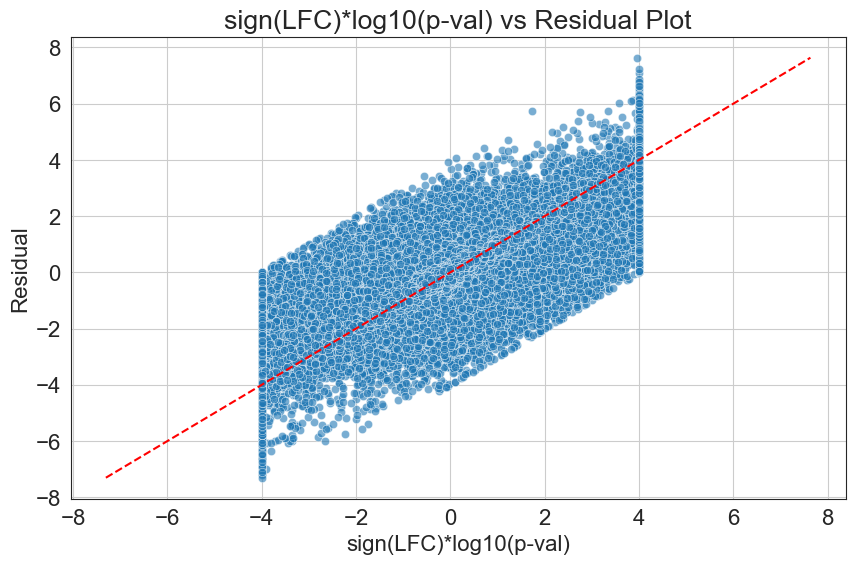

In [463]:
plt.figure(figsize=(10, 6))
plt.scatter(val, errors, alpha=0.6, edgecolors='w', linewidth=0.5)
x_y_line_range = [min(val.min(), errors.min()), max(val.max(), errors.max())]
plt.plot(x_y_line_range, x_y_line_range, 'r--', label='x=y Line')
plt.title('sign(LFC)*log10(p-val) vs Residual Plot')
plt.xlabel('sign(LFC)*log10(p-val)')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

In [464]:
import seaborn as sns

In [465]:
palette = sns.color_palette("colorblind")

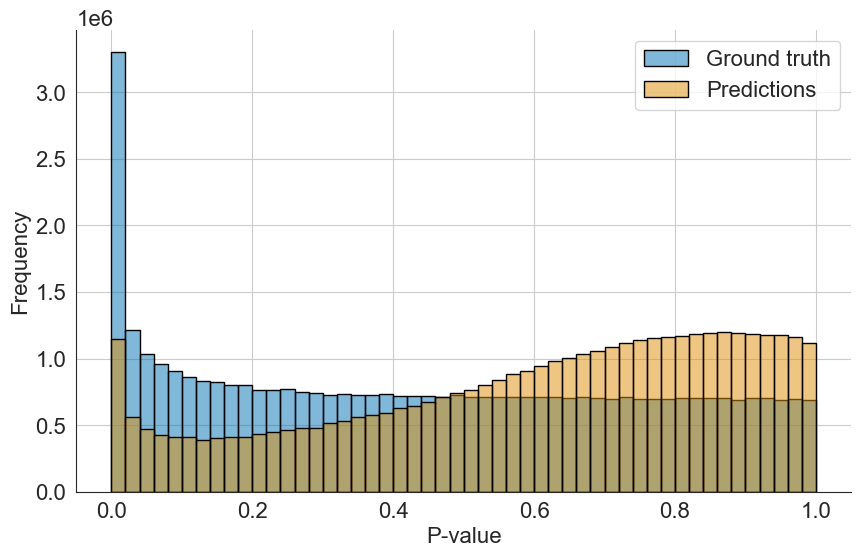

In [466]:
sns.set_style("whitegrid")
sns.set_style("white")
plt.figure(figsize=(10, 6))

# plot distribution
ax = sns.histplot(10**-np.abs(val), color=palette[0], bins=50, edgecolor='black', label='Ground truth', alpha=0.5, stat="frequency")

# Plot histogram for val2
sns.histplot(10**-np.abs(pred), color=palette[1], bins=50, edgecolor='black', label='Predictions', alpha=0.5, stat="frequency", ax=ax)

# Adding labels and title
plt.title('Distribution of predictions and ground truth')
plt.xlabel('P-value')
plt.ylabel('Frequency')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adding legend to distinguish the two distributions
plt.legend()

# Show plot with grid
plt.grid(True)
plt.savefig("predictions_vs_ground_truth_p_val.svg", transparent=True)
plt.title("")
plt.show()

In [467]:
pred.min()

-4.0

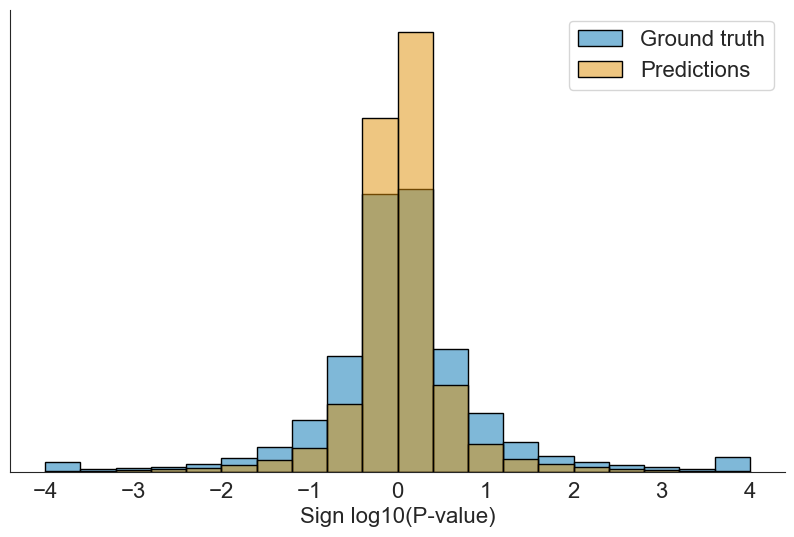

In [468]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set_style("white")  # This will override the whitegrid if called after

# Initialize the figure with a specified size
plt.figure(figsize=(10, 6))

# Assuming 'val' and 'pred' are your data variables and 'palette' is defined
ax = sns.histplot(val, color=palette[0], bins=20, edgecolor='black', label='Ground truth', alpha=0.5)
sns.histplot(pred, color=palette[1], bins=20, edgecolor='black', label='Predictions', alpha=0.5)

# Set the title and labels
plt.title('')
plt.xlabel('Sign log10(P-value)')
plt.ylabel('')

# Hide y-axis ticks
plt.yticks([])

# Add legend
plt.legend()

# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the plot with transparency
plt.savefig("predictions_vs_ground_truth.svg", transparent=True)

# Display the plot
plt.show()